In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import graphviz 

%matplotlib inline

C:\Users\mayan\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("data/housing.csv")

In [3]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df=df[select_cols]

In [4]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.

In [5]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:

df["median_house_value"] = np.log(df["median_house_value"])

df_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_train,test_size=0.25,random_state=1)

In [6]:
X_col = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]
y_col = "median_house_value"

X_train, y_train = df_train[X_col], df_train[y_col]
X_val, y_val     = df_val[X_col],   df_val[y_col]
X_test, y_test   = df_test[X_col],  df_test[y_col]

- We will use `DictVectorizer` to turn train and validation into matrices.

In [7]:
#@ IMPLEMENTATION OF DICTVECTORIZER:

X_train_dict = X_train.to_dict(orient='records')
X_val_dict   = X_val.to_dict(orient='records')
X_test_dict  = X_test.to_dict(orient='records')


dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)
X_val   = dv.transform(X_val_dict)
X_test  = dv.transform(X_test_dict)

columns = dv.feature_names_

__Question 1__

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

Which feature is used for splitting the data?

- `ocean_proximity=INLAND`
- `total_rooms`
- `latitude`
- `population`

In [8]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

[Text(0.5, 0.75, 'ocean_proximity=INLAND <= 0.5\nsquared_error = 0.322\nsamples = 12384\nvalue = 12.088'),
 Text(0.25, 0.25, 'squared_error = 0.214\nsamples = 8483\nvalue = 12.307'),
 Text(0.75, 0.25, 'squared_error = 0.227\nsamples = 3901\nvalue = 11.613')]

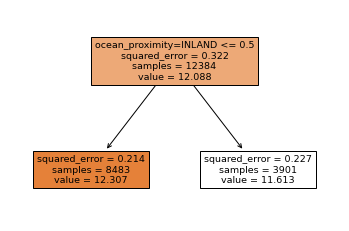

In [9]:
#@ INSPECTION:
tree.plot_tree(dt,
               feature_names = dv.feature_names_, 
               class_names=y_train,
               filled = True)

__ANSWER__ option `a) `__ocean_proximity=INLAND__

__Quesiton 2__

Train a random forest model with these parameters:

- `n_estimators=10`

- `random_state=1`

- `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

- 0.05
- 0.25
- 0.55
- 0.85

In [10]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
#@ CALCULATING MEAN SQUARED ERROR:
y_val_pred = rf.predict(X_val)
rmse = round(mean_squared_error(y_val, y_val_pred)**.5,2)
print(rmse)

0.25


__ANSWER__ option `b) `__0.25__

__Question 3__

Now let's experiment with the `n_estimators` parameter

Try different values of this parameter from 10 to 200 with step 10.
Set `random_state` to 1.

Evaluate the model on the validation dataset.
After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150

In [12]:
est_rmse = {}

n_est = list(range(10,201,10))
for curr_est in n_est:
    #@ TRAINING RANDOM FOREST MODEL:
    rf = RandomForestRegressor(n_estimators=curr_est,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)
    y_val_pred = rf.predict(X_val)
    rmse = round(mean_squared_error(y_val, y_val_pred)**.5,4)
    
    est_rmse[curr_est]=rmse

In [13]:
#@ INSPECTING THE RMSE SCORES:
lists = est_rmse.items()
est,rmse = zip(*lists)

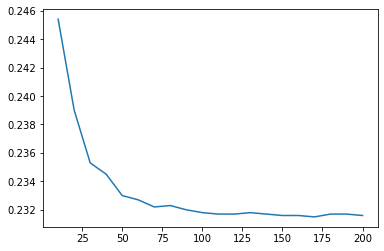

In [14]:
plt.plot(est, rmse)
plt.show()

In [15]:
est_rmse

{10: 0.2454,
 20: 0.239,
 30: 0.2353,
 40: 0.2345,
 50: 0.233,
 60: 0.2327,
 70: 0.2322,
 80: 0.2323,
 90: 0.232,
 100: 0.2318,
 110: 0.2317,
 120: 0.2317,
 130: 0.2318,
 140: 0.2317,
 150: 0.2316,
 160: 0.2316,
 170: 0.2315,
 180: 0.2317,
 190: 0.2317,
 200: 0.2316}

__Answer__ option `b) `__50__

__Question 4__

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25]
- For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
- Fix the random seed: `random_state=1`

What's the best max_depth:

- 10
- 15
- 20
- 25

In [16]:
depth_mean_rmse = {}

depth = list(range(10,26,5))
n_est = list(range(10,201,10))

for curr_depth in depth:
    rmses = []
    for curr_est in n_est:
        #@ TRAINING RANDOM FOREST MODEL:
        rf = RandomForestRegressor(n_estimators=curr_est,random_state=1,n_jobs=-1,max_depth=curr_depth)
        rf.fit(X_train,y_train)
        y_val_pred = rf.predict(X_val)
        rmse = round(mean_squared_error(y_val, y_val_pred)**.5,5)
        rmses.append(rmse)
        
    depth_mean_rmse[curr_depth]= round(sum(rmses)/len(rmses),5)

In [17]:
depth_mean_rmse

{10: 0.25004, 15: 0.23504, 20: 0.23347, 25: 0.23343}

In [18]:
#@ INSPECTING THE RMSE SCORES:
lists = depth_mean_rmse.items()
depth,rmse = zip(*lists)

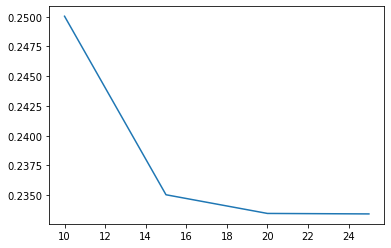

In [19]:
plt.plot(depth, rmse)
plt.show()

__Answer__ option `b) `__25__

__Question 5__

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

- Train the model with these parametes

  - `n_estimators=10`,

  - `max_depth=20`,

  - `random_state=1`,

  - `n_jobs=-1` (optional)



- Get the feature importance information from this model

What's the most important feature?

- `total_rooms`

- `median_income`

- `total_bedrooms`

- `longitude`


In [20]:
#@ TRAINING THE RANDOM FOREST MODEL:

rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1,max_depth=20)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

<BarContainer object of 13 artists>

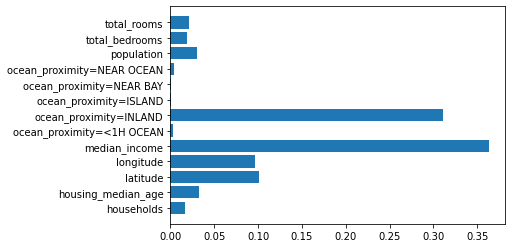

In [21]:
plt.barh(dv.feature_names_, rf.feature_importances_)

__Answer__ option `b) `__median_income__

__Question 6__

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:
    
```python
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta first to 0.1 and then to 0.01

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both gives same

In [22]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [23]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain, num_boost_round=100)

y_val_pred = model.predict(dval)
rmse_01 = round(mean_squared_error(y_val,y_val_pred)**.5,4)

In [24]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain, num_boost_round=100)

y_val_pred = model.predict(dval)
rmse_03    = round(mean_squared_error(y_val,y_val_pred)**.5,4)

In [25]:
rmse_01==rmse_03

False

In [26]:
rmse_01

0.2325

In [27]:
rmse_03

0.2278

__Answer__ option `b) `__0.1__